# Code for more tranditional compression experiments

In [149]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_compression as tfc
import re
import random
import numpy as np
import os
from astropy.io import fits

# Specify the directory containing the .tar files
directory_path = './columbialensing/'
number_image_files = 512

single_cosmology = True #if true, only use one cosmology
# image_size
image_size = 1024
sub_image_size = 256 #needs to divide image into these units; must divide evenly image_size
                    #division is using that it is unlikely there are learnable correlations
                    #that allow one to compress the data on large scales in the images
                    #dividing images gives more samples to learn correlations

num_images_use = image_size**2//sub_image_size**2*number_image_files

number_subimages_across =image_size//sub_image_size



suffix = f"_{image_size}"
extract_tarfiles = False  #if I need to extract tarfiles

run_suffix = rf"im{image_size}"



def get_labels_for_file(dir_name):
    """
    Extracts labels from the tar file name.
    For the file "Om0.183_si0.958_256.tar", the labels will be [0.183, 0.958].

    Args:
    - tar_file_name (str): Name of the tar file.

    Returns:
    - list: List containing the two labels extracted from the filename.
    """
    # Split the filename on underscores
    if dir_name.endswith('.tar'):
        dir_name = dir_name[:-4]

    parts = dir_name.split('_')

    # Extract the numeric values for 'Om' and 'si'
    om_label = float(parts[0][2:])
    si_label = float(parts[1][2:])
    print (om_label, si_label)

    return [om_label, si_label]

#selects the numdirs closest to the fiducial directory
#STILL WORKING ON THIS CODE
def select_some_directories(numdirs, fiducial_dir):
    all_directories = [f for f in os.listdir(directory_path) if '128' not in f and '256' not in f]
    print(all_directories)
    #cosmology_labels = np.empty((len(all_directories), number_images, 2), dtype=np.float16)
    fiducial_label = get_labels_for_file(fiducial_dir)
    labels = [get_labels_for_file(directory) for directory in all_directories] 
    print(labels)
    #to evlauate closeness
    closeness = pow(labels[:][0]/.3, 0.5)*label[:][1]
    fiducial = pow(fiducial_label[0]/.3, 0.5)*fiducial_label[1]

    #sort by closeness
    sorted_closeness = np.argsort(np.abs(closeness-fiducial))
    #select numdirs closest
    selected_dirs = sorted_closeness[:numdirs]
    return [all_directories[i] for i in selected_dirs]

#now loop through all files in the
pattern = re.compile(rf"{suffix}$")

if single_cosmology:
    all_directories = ["Om0.268_si0.801"] # "Om0.283_si0.805_256"
else:
    numdirs = 10
    all_directories = select_some_directories(numdirs, "Om0.268_si0.801")
    print(all_directories)


num_cosmologies = len(all_directories)

random.shuffle(all_directories) #this makes it so that there is no particular order for the directories
#print(all_directories)

#tensor of labels; there are two labels for each
numsubimages = number_subimages_across**2
number_images = number_image_files*numsubimages
#cosmology_labels = np.empty((len(all_directories), number_images, 2), dtype=np.float16)

RMS =0 #first time set to zero
data_array = np.empty((num_cosmologies, number_images, sub_image_size, sub_image_size), dtype=np.float32)
for idy, dir_name in enumerate(all_directories):


    #if idy%10 ==0:
    print("reading in", dir_name)
    dir_path = os.path.join(directory_path, dir_name)

    all_files = os.listdir(dir_path)
    fits_files = [f for f in all_files if f.endswith('.fits')]



    for idx, file in enumerate(fits_files):
        with fits.open(os.path.join(dir_path, file)) as hdul:

            original_data = hdul[0].data #take log of data 

            if RMS == 0: #get RMS to divide by for first file to normalize everything
                RMS = np.sqrt(np.var(hdul[0].data))
                print(f"RMS={RMS}")

            ##get rid of NANs, which affects a few files
            #if np.isnan(original_data).any():
            #    continue
            #I've cleaned this out already
            for i in range(number_subimages_across):
                for j in range(number_subimages_across):
                    data_array[idy][numsubimages*idx+ number_subimages_across*i+j] = original_data[sub_image_size*i:sub_image_size*(i+1),\
                                                                  sub_image_size*j:sub_image_size*(j+1)]
    #since all fits files in one directory have the same label
    cosmology = get_labels_for_file(dir_name)
    #cosmology_labels[idy] = np.array([cosmology for i in range(number_fits_files)])


    #flatten data_array[idy][numsubimages*idx+ number_subimages_across*i+j]
WL_tensor = tf.convert_to_tensor(data_array)

WL_tensor = tf.reshape(WL_tensor, (-1, WL_tensor.shape[2], WL_tensor.shape[3]));

WL_tensor = WL_tensor[..., np.newaxis]  # Add channel dimension




reading in Om0.268_si0.801
RMS=0.018752897158265114
0.268 0.801


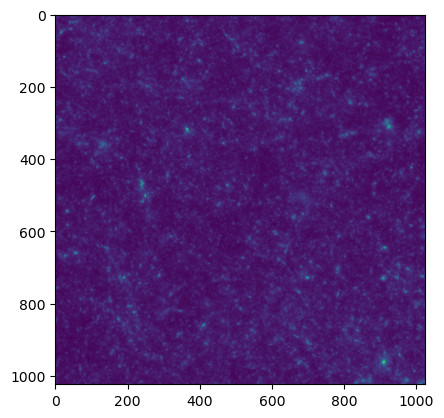

In [141]:
dataset = tf.data.Dataset.from_tensor_slices(WL_tensor)
#training_dataset = dataset.take(train_size)
(originals), =  dataset.batch(num_images_use).take(1) #simpler problem to start with

plt.imshow(tf.squeeze(originals[255]))

725 [[  0.           1.           2.         ... 510.         511.
  512.        ]
 [  1.           1.41421356   2.23606798 ... 510.00098039 511.00097847
  512.00097656]
 [  2.           2.23606798   2.82842712 ... 510.00392155 511.00391388
  512.00390624]
 ...
 [  3.           3.16227766   3.60555128 ... 510.00882345 511.00880619
  512.00878899]
 [  2.           2.23606798   2.82842712 ... 510.00392155 511.00391388
  512.00390624]
 [  1.           1.41421356   2.23606798 ... 510.00098039 511.00097847
  512.00097656]]


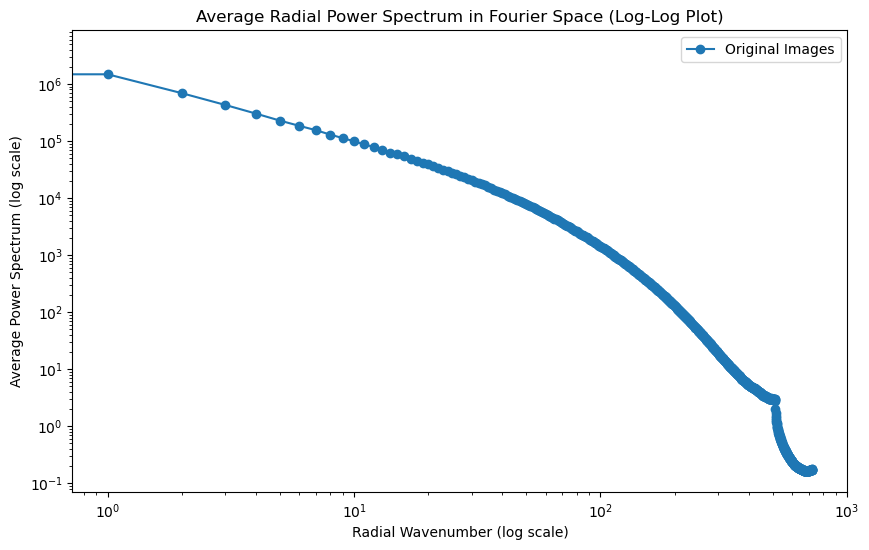

In [142]:
def fft_radial_distance(shape):
    # Create indices for the Fourier space
    kx, ky = np.meshgrid(np.fft.rfftfreq(shape), np.fft.fftfreq(shape))
    k = np.sqrt(kx**2 + ky**2)*sub_image_size  # Calculate radial distance in Fourier space
    return k

def radial_bin_average(image_fft, radial_dist):
    # Calculate the magnitude of the FFT (power spectrum)
    magnitude = np.abs(image_fft)**2

    # Bin the values based on radial distance
    radial_dist_int = np.rint(radial_dist).astype(int)
    tbin = np.bincount(radial_dist_int.ravel(), magnitude.ravel())
    nr = np.bincount(radial_dist_int.ravel())
    #print(tbin, nr)
    radial_profile = tbin / nr
    return radial_profile

def radial_bin_average_cross(image_fft1, image_fft2, radial_dist):
    # Calculate the magnitude of the FFT (power spectrum)
    magnitude = np.abs(image_fft1*np.conj(image_fft2))

    # Bin the values based on radial distance
    radial_dist_int = np.rint(radial_dist).astype(int)
    tbin = np.bincount(radial_dist_int.ravel(), magnitude.ravel())
    nr = np.bincount(radial_dist_int.ravel())
    #print(tbin, nr)
    radial_profile = tbin / nr
    return radial_profile

def average_fft_power_spectrum(fftimages, shape):
    num_images = len(fftimages)
    radial_dist = fft_radial_distance(shape)
    
    # Calculate the maximum bin index, rounding up to the nearest integer
    max_bin_index = int(np.ceil(np.max(radial_dist)))
    print(max_bin_index, radial_dist)
    
    # Initialize the sum of radial power spectra
    sum_radial_power_spectrum = np.zeros(max_bin_index)
    
    for fftimage in fftimages:
        #fftimage = np.fft.fftshift(fftimage)
        radial_power_spectrum = radial_bin_average(fftimage, radial_dist)
        sum_radial_power_spectrum += radial_power_spectrum
    
    # Average across all images
    avg_radial_power_spectrum = sum_radial_power_spectrum / num_images
    return avg_radial_power_spectrum


def average_fft_cross_power_spectrum(fftimages1, fftimages2, shape):
    num_images1 = len(fftimages1); num_images2 = len(fftimages2)

    if(num_images1 != num_images2):
        print("number of images in each set must be the same:", num_images1, num_images2, "Aborting")
        return
    
    radial_dist = fft_radial_distance(shape)
    
    # Calculate the maximum bin index, rounding up to the nearest integer
    max_bin_index = int(np.ceil(np.max(radial_dist)))
    
    # Initialize the sum of radial power spectra
    sum_radial_power_spectrum = np.zeros(max_bin_index)

    for fftimage1, fftimage2 in zip(fftimages1, fftimages2):
        #fftimage = np.fft.fftshift(fftimage)
        radial_power_spectrum = radial_bin_average_cross(fftimage1, fftimage2, radial_dist)
        sum_radial_power_spectrum += radial_power_spectrum
    
    # Average across all images
    avg_radial_power_spectrum = sum_radial_power_spectrum / num_images1
    return avg_radial_power_spectrum

#fft's of array
fftimages = [np.fft.rfft2(image) for image in tf.squeeze(originals)]
avg_power = np.mean(np.abs(fftimages))

avg_radial_power_spectrum_originals = average_fft_power_spectrum(fftimages, sub_image_size) # does not need to be subimage size

plt.figure(figsize=(10, 6))

# Plot for originals with markers
plt.loglog(avg_radial_power_spectrum_originals, label='Original Images', marker='o', linestyle='-')

#plt.loglog(average_fft_cross_power_spectrum(fftimages,fftimages, sub_image_size), label='cross', marker='x', linestyle='-') #for testing

plt.xlabel('Radial Wavenumber (log scale)')
plt.ylabel('Average Power Spectrum (log scale)')
plt.title('Average Radial Power Spectrum in Fourier Space (Log-Log Plot)')
plt.legend()

plt.show()



(128, 128, 65)
(128, 65)
num pixels less than one: 0


2.016747270518859

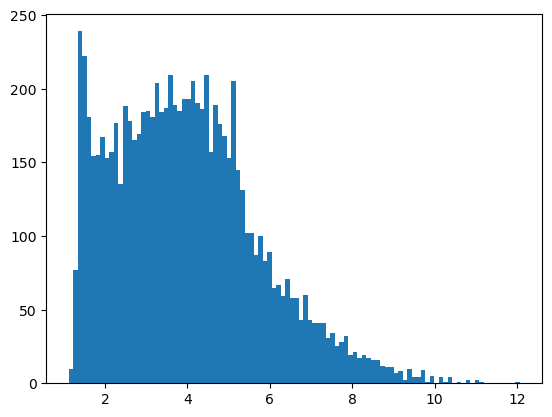

In [ ]:
#THIS DOES NOT SEEM CORRECT.....SEE LATER CALCULATION

import matplotlib.pyplot as plt

#estimate number of pixels required to compress image with distortion D
D = 1e-4 #distortion

print(np.shape(fftimages))
#number of pixels required to compress image with distortion D
def num_bits_needed(D):
    pixel_variance = np.var(fftimages, axis=0)
    avg =np.average(pixel_variance)/np.sqrt(2) #divided by sqrt2 is because imaginary and real components are included in variance and each need to be separately encoded
    print(np.shape(pixel_variance))

    #really should set 

    # Assuming pixel_variance, D, and avg are defined
    condition = pixel_variance/(D*avg) < 1
    num_pixels_less_than_one = np.sum(condition)
    print(f"num pixels less than one: {num_pixels_less_than_one}")
    
    bits = 0.5*np.log2(pixel_variance/(D*avg))   # to do correct optimization should do pixel_variance[condition]
    

    plt.hist(bits.flatten(), bins=100)
    return np.sum(bits)/sub_image_size**2


num_bits_needed(D)

## the following is only used if "true quantization" is on

In [94]:
# tfc.NoisyNormal(loc=0., scale=tf.exp(self.prior_log_scales))   

#entropy_model = tfc.ContinuousBatchedEntropyModel(
#          self.prior, coding_rank=1, compression=False)

class Compressor(tf.keras.Model):
  """Compresses images to strings."""

  def __init__(self, entropy_model):
    super().__init__()
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype)  #/ 255.
  
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(x, training=False)
    return self.entropy_model.compress(x), bits
  
class Decompressor(tf.keras.Model):
  """Decompresses images from strings."""

  def __init__(self, entropy_model):
    super().__init__()
    self.entropy_model = entropy_model

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    # Scale and cast back to 8-bit integer.
    return y_hat #tf.saturate_cast(tf.round(x_hat), tf.uint8)





# The following takes FFTs of each image and quantizes (This uses the above and is super slow if true_quantization is on)

In [95]:
accuracy = 100  # part in one hundred accuracy
true_quantization = 0
if true_quantization:
    print("initializing entropy model...")
    #entropy_model = tfc.ContinuousBatchedEntropyModel(prior_shape=tfc.NoisyLogistic(loc=0., scale=(accuracy)), coding_rank=1, compression=True)
    #entropy_model = tfc.ContinuousBatchedEntropyModel(prior=tfc.NoisyNormal(loc=0., scale=(accuracy)), coding_rank=1, compression=True)
    entropy_model = tfc.ContinuousBatchedEntropyModel(tfc.NoisyLogistic(loc=0., scale=(accuracy*np.ones(sub_image_size*(sub_image_size+2)//2))), coding_rank=1, compression=True)
    print("entropy model initialized")
    compressor = Compressor(entropy_model)
    decompressor = Decompressor(entropy_model)

kx, ky = np.meshgrid(np.fft.rfftfreq(sub_image_size), np.fft.fftfreq(sub_image_size))
k = np.sqrt(kx**2 + ky**2)*sub_image_size  # Calculate radial distance in Fourier space

print(np.round(k[::16, ::16]))
sqrt2times_avg_radial_power = (2*avg_radial_power_spectrum_originals[np.round(k).astype(int)])**.5 #why sqrt 2?



fftimages_round = fftimages.copy()
num_images_round = 10 #len(fftimages)
for i in range(num_images_round):
    print("image", i)

    if true_quantization:
        fftimages_round[i] = fftimages_round[i] / sqrt2times_avg_radial_power
        
        
        real = tf.convert_to_tensor(np.real(accuracy*fftimages_round[i]), dtype=np.float32) #should convert to 32 earlier

        imag = tf.convert_to_tensor(np.imag(accuracy*fftimages_round[i]), dtype=np.float32) #should convert to 32 earlier
        #print("real.shape = ", real.shape)
        real = tf.reshape(real, [-1]); imag = tf.reshape(imag, [-1])
        comp_real,  rbits= compressor(real)
        comp_imag,  ibits= compressor(imag)

        print("bits = ", rbits+ibits)
        real = decompressor(comp_real); imag = decompressor(comp_imag)
        real = tf.reshape(real, [sub_image_size, -1]);  imag = tf.reshape(imag, [sub_image_size, -1])
        #print("real.shape = ", real.shape, imag.shape)
    
        #print("mean = ", np.mean(np.abs(fftimage_round)*2))
        #rounding
        #print(entropy_model.decompress(comp_real, shape))
        fftimages_round[i]  = (real.numpy() + 1j*imag.numpy())/accuracy*sqrt2times_avg_radial_power
        #print(comp_real.shape, fftimages_round[i].shape,  fftimages_round[i])

        #this was my simple rounding
    else: #pseudo-quantization
        fftimages_round[i] = np.round(fftimages_round[i] * accuracy) / accuracy * sqrt2times_avg_radial_power




rounded_images = [np.fft.irfft2(fftimage_round) for fftimage_round in fftimages_round]

#rounded_images  = rounded_images[..., np.newaxis] 

[[  0.  16.  32. ... 480. 496. 512.]
 [ 16.  23.  36. ... 480. 496. 512.]
 [ 32.  36.  45. ... 481. 497. 513.]
 ...
 [ 48.  51.  58. ... 482. 498. 514.]
 [ 32.  36.  45. ... 481. 497. 513.]
 [ 16.  23.  36. ... 480. 496. 512.]]
image 0
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9


# Loyd max quantizer 

In [96]:
import numpy as np
from scipy.stats import norm
from scipy.special import erf

def lloyd_max_quantizer(mu, sigma, levels):
    # Initialize decision boundaries
    decision_boundaries = np.linspace(mu - nsigma_consider*sigma, mu + nsigma_consider*sigma, levels+1)

    # Initialize reconstruction levels
    reconstruction_levels = np.zeros(levels)

    while True:
        # Update reconstruction levels
        for i in range(levels):
            left_boundary = decision_boundaries[i]
            right_boundary = decision_boundaries[i+1]
            #reconstruction_levels[i] = norm.expect(lambda x: x, args=(mu, sigma), lb=left_boundary, ub=right_boundary) / \
            #                           norm.expect(lambda x: 1, args=(mu, sigma), lb=left_boundary, ub=right_boundary)
            reconstruction_levels[i] = norm.expect(lambda x: x, loc=mu, scale=sigma, lb=left_boundary, ub=right_boundary) / \
                           norm.expect(lambda x: 1, loc=mu, scale=sigma, lb=left_boundary, ub=right_boundary)

        

        # Update decision boundaries
        new_decision_boundaries = (reconstruction_levels[:-1] + reconstruction_levels[1:]) / 2

        # Check for convergence
        if np.allclose(new_decision_boundaries, decision_boundaries[1:-1]):
            break

        decision_boundaries[1:-1] = new_decision_boundaries

    return decision_boundaries, reconstruction_levels


def uniform_quantizer(mu, sigma, levels):
    # Calculate the step size



    if(sigma !=1 or mu !=0):
        print("Warning: uniform quantizer assumes mu=0 and sigma=1")
        return -1

    reconstruction_levels = np.zeros(levels)    
    # Initialize decision boundaries
    decision_boundaries = np.linspace(mu - nsigma_consider*sigma, mu + nsigma_consider*sigma, levels+1)
    #print("len decision boundaries", len(decision_boundaries), level+1)

    # Initialize reconstruction levels
    xc =(decision_boundaries[:-1] + decision_boundaries[1:]) / 2
    dx = decision_boundaries[1:] - decision_boundaries[:-1]

    #integrate gaussian to get correct mean
    result = ((np.exp(-(1/8) * (-2 * xc + dx)**2) - np.exp(-(1/8) * (2 * xc + dx)**2)) * np.sqrt(2/np.pi)) / (-erf((xc - dx/2) / np.sqrt(2)) + erf((xc + dx/2) / np.sqrt(2)))
    reconstruction_levels =  result                          #xc*(1 - dx**2/12 + (2+xc**2)*dx**4/720)  #Taylor expansion of Gaussian

    return decision_boundaries, reconstruction_levels

# Test the function
mu = 0
sigma = 1
max_levels = 30000
max_levels_lloyd_max = 0 #5
nsigma_consider = 8 #how many sigma to consider for quantization

quantization_values = {}

for levels in range(1, max_levels):
    if levels < max_levels_lloyd_max:
        decision_boundaries, reconstruction_levels = lloyd_max_quantizer(mu, sigma, levels)
    else:  
        decision_boundaries, reconstruction_levels = uniform_quantizer(mu, sigma, levels)

    if levels < 10:
        print("level = " , levels)
        print("Decision boundaries: ", decision_boundaries)
        
        print("Reconstruction levels: ", reconstruction_levels)


    quantization_values[levels] = [decision_boundaries, reconstruction_levels]

kx, ky = np.meshgrid(np.fft.rfftfreq(sub_image_size), np.fft.fftfreq(sub_image_size))
k = np.sqrt(kx**2 + ky**2)*sub_image_size  # Calculate radial distance in Fourier space

#print(np.round(k[::16, ::16]))


level =  1
Decision boundaries:  [-8.  8.]
Reconstruction levels:  [0.]
level =  2
Decision boundaries:  [-8.  0.  8.]
Reconstruction levels:  [-0.79788456  0.79788456]
level =  3
Decision boundaries:  [-8.         -2.66666667  2.66666667  8.        ]
Reconstruction levels:  [-2.97515764e+00 -2.51062968e-17  2.97515764e+00]
level =  4
Decision boundaries:  [-8. -4.  0.  4.  8.]
Reconstruction levels:  [-4.22560714 -0.79766743  0.79766743  4.22560714]
level =  5
Decision boundaries:  [-8.  -4.8 -1.6  1.6  4.8  8. ]
Reconstruction levels:  [-4.99326676e+00 -2.02408600e+00  3.48202988e-16  2.02408600e+00
  4.99326676e+00]
level =  6
Decision boundaries:  [-8.         -5.33333333 -2.66666667  0.          2.66666667  5.33333333
  8.        ]
Reconstruction levels:  [-5.50950996 -2.97512574 -0.78107623  0.78107623  2.97512574  5.50950996]
level =  7
Decision boundaries:  [-8.         -5.71428571 -3.42857143 -1.14285714  1.14285714  3.42857143
  5.71428571  8.        ]
Reconstruction levels: 

/var/folders/wm/r259x5453lgbh9fmt19f54940000gn/T/ipykernel_56599/2194322739.py:55: RuntimeWarning: divide by zero encountered in divide
  result = ((np.exp(-(1/8) * (-2 * xc + dx)**2) - np.exp(-(1/8) * (2 * xc + dx)**2)) * np.sqrt(2/np.pi)) / (-erf((xc - dx/2) / np.sqrt(2)) + erf((xc + dx/2) / np.sqrt(2)))


/var/folders/wm/r259x5453lgbh9fmt19f54940000gn/T/ipykernel_56599/1626300190.py:77: RuntimeWarning: divide by zero encountered in log2
  entropy[level] = -np.sum(probability_values*np.log2(probability_values))
/var/folders/wm/r259x5453lgbh9fmt19f54940000gn/T/ipykernel_56599/1626300190.py:77: RuntimeWarning: invalid value encountered in multiply
  entropy[level] = -np.sum(probability_values*np.log2(probability_values))


db shapes  (30001,) (30000,)


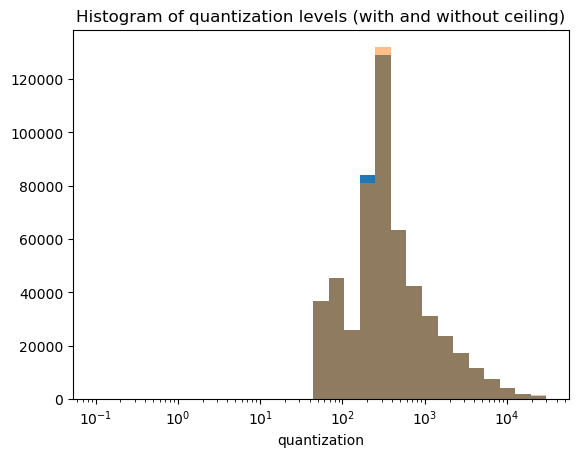

image 0
image 1
image 2
avg level=  884.8027457967836
rate estimate =  8.54159101412225 true minimum =  6.331156040614987  bits/pixel
First is not quite right as it is not taking into account the fact that the levels are not equally likely and second should be min possible for distortion D
better rate estimate =  nan bits/pixel (should really be above theoretical min...something is up)


In [99]:
kx, ky = np.meshgrid(np.fft.rfftfreq(sub_image_size), np.fft.fftfreq(sub_image_size))
k = np.sqrt(kx**2 + ky**2)*sub_image_size  # Calculate radial distance in Fourier space
avg_radial_power = avg_radial_power_spectrum_originals[np.round(k).astype(int)]
sqrt_avg_radial_power = np.sqrt(avg_radial_power/2) #2 is because of real and imaginary parts


def quantize_image(image, level, decision_boundaries, reconstruction_levels, single_level = False):
    # Create arrays to hold the quantized real and imaginary parts
    quantized_real = np.zeros_like(image.real)
    quantized_imag = np.zeros_like(image.imag)

    # Loop over each level
    for i in range(max_levels-1):
        #print(i, np.shape(image.real), np.shape(level), np.shape(decision_boundaries[level]), np.shape(decision_boundaries[level][i+1]))
        # Find the pixels in the current level for the real part
        if i == 0:  # For the first level, include the left boundary
            in_level_real = (image.real >= decision_boundaries[level, i]) & (image.real < decision_boundaries[level, i+1])
        else:  # For other levels, do not include the left boundary
            in_level_real = (image.real > decision_boundaries[level, i]) & (image.real <= decision_boundaries[level, i+1])

        # Set these pixels to the corresponding reconstruction level
        #print("new shapes ", np.shape(reconstruction_levels[level, i]), np.shape(quantized_real[in_level_real]))
        
        if single_level:
            quantized_real[in_level_real] = reconstruction_levels[level, i]
        else:
            quantized_real[in_level_real] = reconstruction_levels[level[in_level_real], i]

        # Repeat for the imaginary part
        if i == 0:
            in_level_imag = (image.imag >= decision_boundaries[level, i]) & (image.imag < decision_boundaries[level, i+1])
        else:
            in_level_imag = (image.imag > decision_boundaries[level, i]) & (image.imag <= decision_boundaries[level, i+1])

        if single_level:
            quantized_imag[in_level_imag] = reconstruction_levels[level, i]
        else:
            quantized_imag[in_level_imag] = reconstruction_levels[level[in_level_imag], i]

    # Combine the quantized real and imaginary parts into a complex array

    quantized_image = quantized_real + 1j*quantized_imag

    return quantized_image


# Get the decision boundaries and reconstruction levels for the desired level
#decision_boundaries, reconstruction_levels = quantization_values[level]

# Initialize lists to store decision boundaries and reconstruction levels
decision_boundaries_list = [[]]
reconstruction_levels_list = [[]]
decision_boundaries_list = np.zeros([max_levels, max_levels+1])
reconstruction_levels_list = np.zeros([max_levels, max_levels])
#probability_values_list = np.zeros([max_levels, max_levels])
entropy = np.zeros(max_levels)

# Loop over each level from 1 to max_level-1
for level in range(1, max_levels):
    decision_boundary, reconstruction_level = quantization_values[level]



    # Create new arrays filled with zeros
    new_decision_boundary = np.zeros(max_levels + 1)
    new_reconstruction_level = np.zeros(max_levels)

    # Copy elements, leaving the ends as zero
    new_decision_boundary[:level+1] = decision_boundary[:level+1]
    new_reconstruction_level[:level] = reconstruction_level[:level]

    decision_boundaries_list[level][:] = new_decision_boundary
    reconstruction_levels_list[level][:] = new_reconstruction_level

    #calculate probabilities
    probability_values =0.5 * (-erf(decision_boundary[:-1] / np.sqrt(2)) + erf(decision_boundary[1:] / np.sqrt(2)))
    entropy[level] = -np.sum(probability_values*np.log2(probability_values))

# Convert lists to arrays
decision_boundaries = np.array(decision_boundaries_list)
reconstruction_levels = np.array(reconstruction_levels_list)

level = 8
print("db shapes ", np.shape(decision_boundaries[level]), np.shape(reconstruction_levels[level]))

fftimages_round = fftimages.copy()

single_level = False
Distortion = 0.0001 #only use if single_level = False
if single_level:
    level = 8
else:
    optimal_arg = np.sqrt(avg_radial_power/(2*avg_power*Distortion))

    #to convert to uniform quantization I should use to get same distortion
    dx = np.sqrt(12)/optimal_arg #for uniform bins
    level_no_ceil = (2*nsigma_consider)/(dx) #ten is because of 10 sigma (should not hard code)
    level = np.minimum(np.ceil(level_no_ceil).astype(int), max_levels-1)  #This is using that bits = 1/2 log2(sigma^2/D) = log2(levels)
    # Calculate the data

    # Plot the histogram
    #print("data shape", np.shape(level_no_ceil))
    plt.hist(level_no_ceil.flatten(),  bins=np.logspace(np.log10(.1), np.log10(max_levels ), 30))  # You can adjust the number of bins as needed
    plt.hist(level.flatten(),  bins=np.logspace(np.log10(.1), np.log10(max_levels), 30), alpha=0.5)
    plt.gca().set_xscale("log")
    plt.xlabel('quantization')
    #plt.ylabel('Frequency')
    plt.title('Histogram of quantization levels (with and without ceiling)')
    plt.show()
    #so that levels = sqrt(sigma^2/D)


#print("shapes ", np.shape(decision_boundaries[level, 3]), np.shape(reconstruction_levels[level, 3]), np.shape(level), np.shape(fftimages_round[i]))

num_images_round = 3
for i in range(num_images_round):
    print("image", i)
    # Quantize the image   
    #print(np.std(fftimages_round[i]/sqrt_avg_radial_power/np.sqrt(2)))
    fftimages_round[i] = quantize_image(fftimages_round[i]/sqrt_avg_radial_power, level, decision_boundaries, reconstruction_levels, single_level )*sqrt_avg_radial_power

rounded_images = [np.fft.irfft2(fftimage_round) for fftimage_round in fftimages_round]



#
if single_level == False:
    print("avg level= ", np.average(level))
    print("rate estimate = ", np.average(np.log2(level)), "true minimum = ", np.average(np.log2(optimal_arg)), ' bits/pixel')
    print('First is not quite right as it is not taking into account the fact that the levels are not equally likely and second should be min possible for distortion D') 
    print("better rate estimate = ", np.average(entropy[level]), 'bits/pixel (should really be above theoretical min...something is up)')

# This makes images of the calculations

-0.032887258066633875 0.50556463
diff_vmin and diff_vmax -0.00023081375 0.0002045352
diff_vmin and diff_vmax -0.01235506 0.010948415


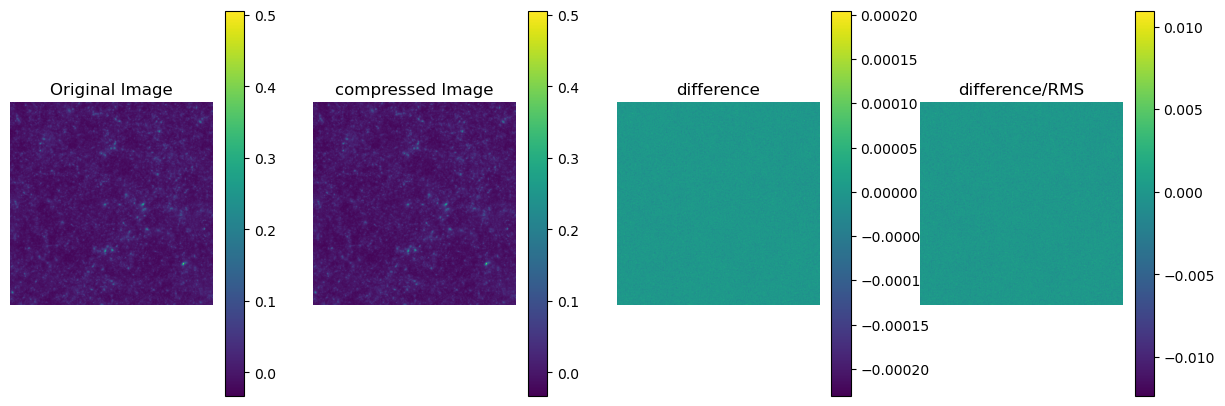

In [100]:
num_image_display = 2


# Assuming originals and reconstructions are your datasets
original_image = tf.squeeze(originals[num_image_display])

rounded_image = rounded_images[num_image_display]

# Determine the min and max values across both images for consistent scaling
vmin = min(original_image.numpy().min(), rounded_image.min())
vmax = max(original_image.numpy().max(), rounded_image.max())
print(vmin, vmax)

# Set up a figure with two subplots
plt.figure(figsize=(15, 5))  # You can adjust the figure size as needed

# Display the original image
plt.subplot(1, 4, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(original_image, vmin=vmin, vmax=vmax)
plt.title('Original Image')
plt.axis('off')  # Turn off axis numbers and labels
plt.colorbar()

# Display the reconstructed image
plt.subplot(1, 4, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(rounded_image, vmin=vmin, vmax=vmax)
plt.title('compressed Image')
plt.axis('off')  # Turn off axis numbers and labels
plt.colorbar()


# Determine the scale for the difference image
difference_image = (original_image - rounded_image) #/np.std(original_image)
diff_vmin = difference_image.numpy().min()
diff_vmax = difference_image.numpy().max()

plt.subplot(1, 4, 3)
print("diff_vmin and diff_vmax",  diff_vmin, diff_vmax)
plt.title('difference')

image_display= plt.imshow(difference_image, vmin=diff_vmin, vmax=diff_vmax)
plt.axis('off')  # Turn off axis numbers and labels
plt.colorbar()

# Determine the scale for the difference image
difference_image = (original_image - rounded_image)/np.std(original_image)
diff_vmin = difference_image.numpy().min()
diff_vmax = difference_image.numpy().max()

plt.subplot(1, 4, 4)
print("diff_vmin and diff_vmax",  diff_vmin, diff_vmax)
plt.title('difference/RMS')

image_display= plt.imshow(difference_image, vmin=diff_vmin, vmax=diff_vmax)


plt.axis('off')  # Turn off axis numbers and labels
plt.colorbar()



# This plots the hitogram of the difference image

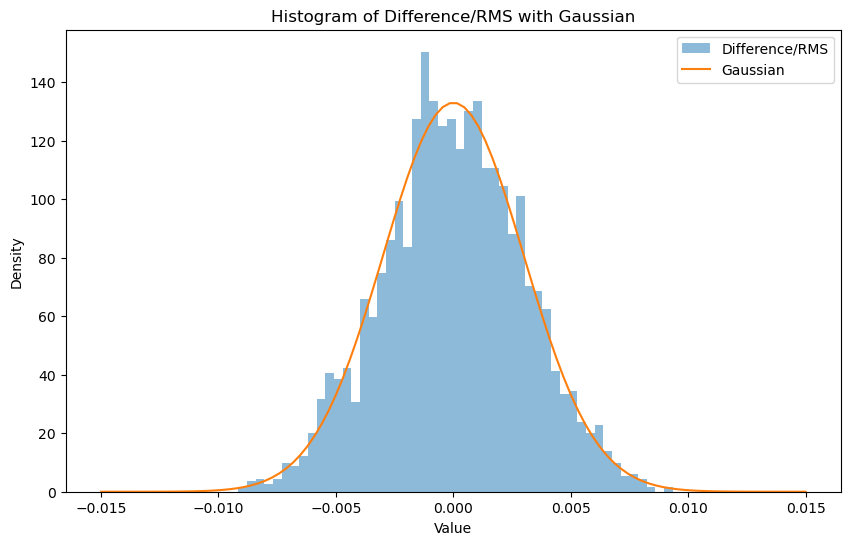

std of difference =  0.0029986277


In [101]:
import numpy as np
from scipy.stats import norm

# Flatten the difference image into a 1D array
difference_images = (original_image[:num_images_round] - rounded_image[:num_images_round])/np.std(original_image[:num_images_round])
difference_flat = difference_images.numpy().flatten()

# Calculate the RMS of the difference
rms = np.sqrt(np.mean(difference_flat**2))

# Generate the x values for the Gaussian
x = np.linspace(-5*rms, 5*rms, 100)

# Generate the y values for the Gaussian
y = norm.pdf(x, 0, rms)
#y = norm.pdf(x, 0, np.sqrt(Distortion))

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the histogram of the difference
plt.hist(difference_flat, bins=50, alpha=0.5, label='Difference/RMS', density=True)

# Plot the Gaussian
plt.plot(x, y, label='Gaussian')

# Set the title and labels
plt.title('Histogram of Difference/RMS with Gaussian')
plt.xlabel('Value')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Display the plot
plt.show()

print("std of difference = ", np.std(difference_flat))

# Let's now compare power spectrum of rounded images to originals

725 [[  0.           1.           2.         ... 510.         511.
  512.        ]
 [  1.           1.41421356   2.23606798 ... 510.00098039 511.00097847
  512.00097656]
 [  2.           2.23606798   2.82842712 ... 510.00392155 511.00391388
  512.00390624]
 ...
 [  3.           3.16227766   3.60555128 ... 510.00882345 511.00880619
  512.00878899]
 [  2.           2.23606798   2.82842712 ... 510.00392155 511.00391388
  512.00390624]
 [  1.           1.41421356   2.23606798 ... 510.00098039 511.00097847
  512.00097656]]
725 [[  0.           1.           2.         ... 510.         511.
  512.        ]
 [  1.           1.41421356   2.23606798 ... 510.00098039 511.00097847
  512.00097656]
 [  2.           2.23606798   2.82842712 ... 510.00392155 511.00391388
  512.00390624]
 ...
 [  3.           3.16227766   3.60555128 ... 510.00882345 511.00880619
  512.00878899]
 [  2.           2.23606798   2.82842712 ... 510.00392155 511.00391388
  512.00390624]
 [  1.           1.41421356   2.23606798

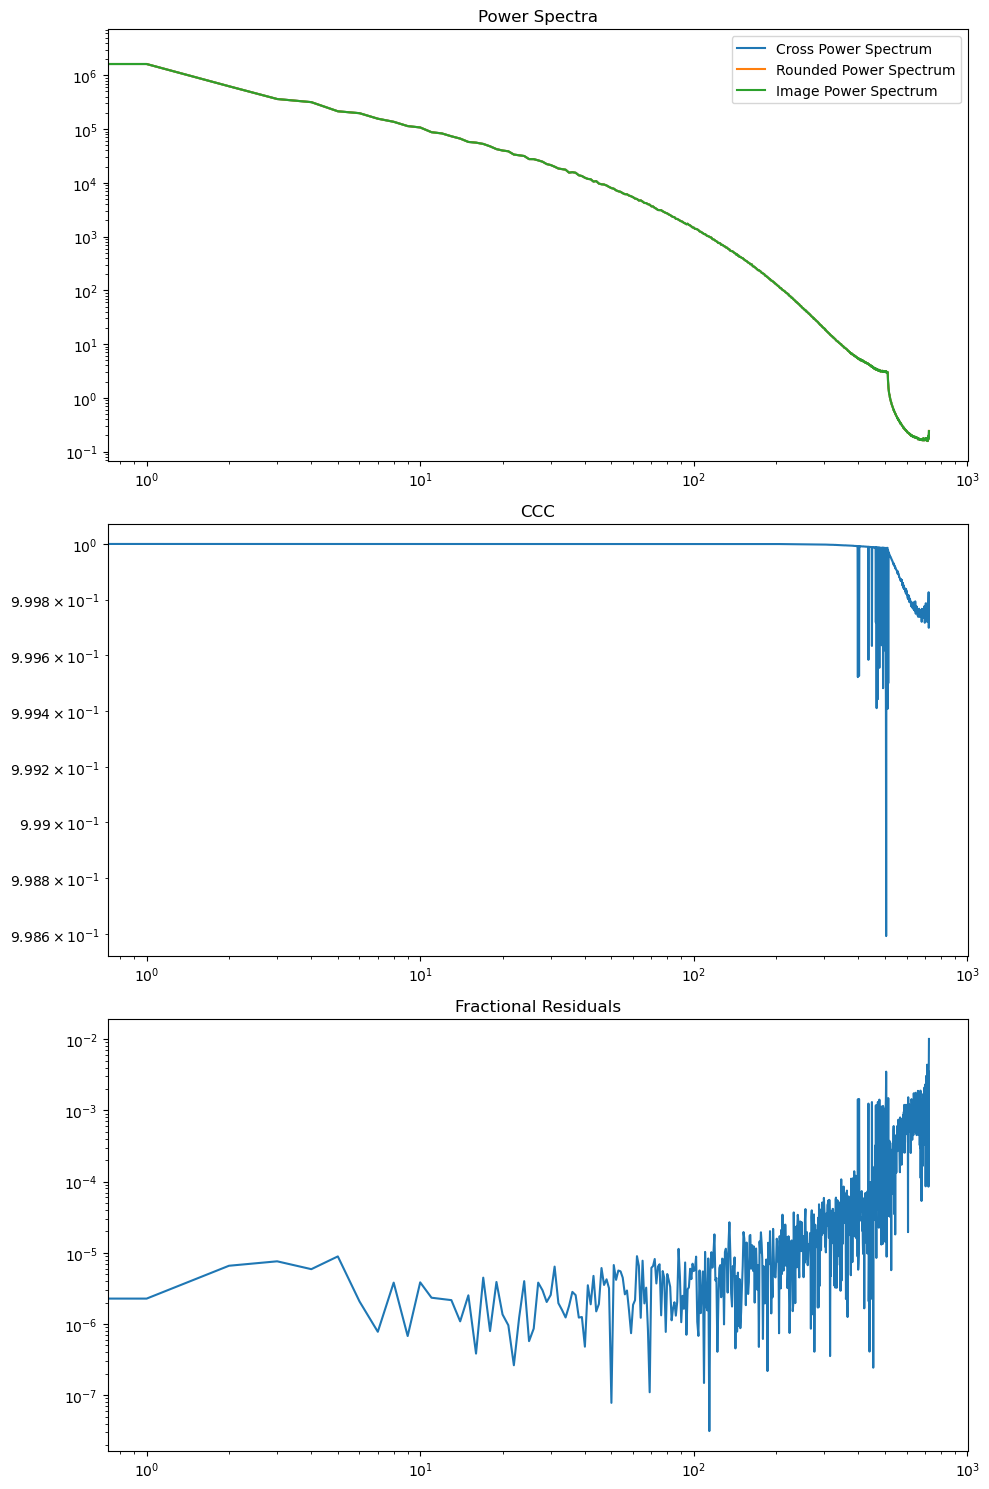

In [102]:
num_images_pk = 20 #len(fftimages_round)  #something is wrong with first image
cross_power = average_fft_cross_power_spectrum(fftimages[:num_images_pk],fftimages_round[:num_images_pk], sub_image_size) #only works if [:num_images_pk] is not added
rounded_power = average_fft_power_spectrum(fftimages_round[:num_images_pk], sub_image_size)
image_power = average_fft_power_spectrum(fftimages[:num_images_pk], sub_image_size)

print(len(cross_power), len(rounded_power), len(image_power))
ccc = cross_power/np.sqrt(rounded_power*image_power)


# Create a figure with 2 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot the power spectra on the first subplot
axs[0].loglog(cross_power, label='Cross Power Spectrum')
axs[0].loglog(rounded_power, label='Rounded Power Spectrum')
axs[0].loglog(image_power, label='Image Power Spectrum')
axs[0].set_title('Power Spectra')
axs[0].legend()

# Plot ccc on the second subplot
axs[1].loglog(ccc)
axs[1].set_title('CCC')

# Plot the fractional residuals on the third subplot
# Calculate the fractional residuals
residuals = np.abs((rounded_power - image_power) / image_power)
axs[2].loglog(residuals)
axs[2].set_title('Fractional Residuals')

# Display the plots
plt.tight_layout()
plt.show()

# code to create a histogram at high wavenumbers to check Gaussian assumption

shape =  (256, 5684)
31.09303913932704


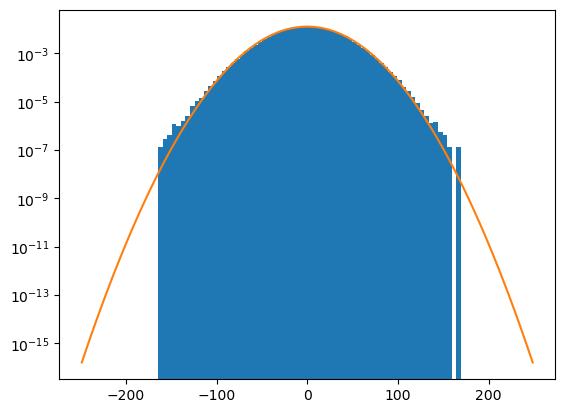

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming fftimages, kx, ky, kmin, kmax, and n are defined
kmin = 80
kmax = 100

# Calculate the radial wavenumber for each entry in fftimages
kx, ky = np.meshgrid(np.fft.rfftfreq(sub_image_size), np.fft.fftfreq(sub_image_size))
k = np.sqrt(kx**2 + ky**2)*sub_image_size 
# Flatten the wavenumber array
#k_flat = k.flatten()

# Create a boolean mask for the desired wavenumber bin
mask = (k >= kmin) & (k < kmax)

# Select the first n images
fftimages_n = [fftimages[i][mask].real for i in range(num_images_use)]

print("shape = ", np.shape(fftimages_n))

# Flatten the images
#fftimages_n_flat = fftimages_n.flatten()



# Apply the mask to the flattened images
fftimages_flatten = np.array(fftimages_n).flatten()

sigma = np.std(fftimages_flatten)
print(sigma)

# Plot the histogram
plt.hist(fftimages_flatten, bins=100, range=[-8*sigma, 8*sigma], density=True)


x = np.linspace(-8*sigma, 8*sigma, 100)

# Generate the y values for the Gaussian
y = norm.pdf(x, 0, sigma)
# Plot the Gaussian
plt.plot(x, y, label='Gaussian')
plt.yscale('log')

plt.show()

# Calculate the KL divergence of box (number of extra bits needed)

numkbins= 23 num_iamges_use= 512
3.0 3.849675741238193 KL div =  0.00018768416041586234 numpix= 22
3.849675741238193 4.940001104225944 KL div =  0.00023352515530429966 numpix= 26
4.940001104225944 6.3391341375428345 KL div =  9.998793099031315e-05 numpix= 64
6.3391341375428345 8.13453696991785 KL div =  9.268800287018389e-05 numpix= 88
8.13453696991785 10.438443213099328 KL div =  7.777328110506136e-05 numpix= 132
10.438443213099328 13.39487387125365 KL div =  7.637050601501704e-05 numpix= 226
13.39487387125365 17.188640333036833 KL div =  4.6572778482820214e-05 numpix= 380
17.188640333036833 22.056897238320094 KL div =  2.963953191421926e-05 numpix= 610
22.056897238320094 28.303967408448187 KL div =  3.92655882651185e-05 numpix= 1008
28.303967408448187 36.32036557103313 KL div =  3.81816710608123e-05 numpix= 1636
36.32036557103313 46.60721008390304 KL div =  4.560440870652748e-05 numpix= 2688
46.60721008390304 59.80754867559788 KL div =  5.683067444955927e-05 numpix= 4430
59.807548675

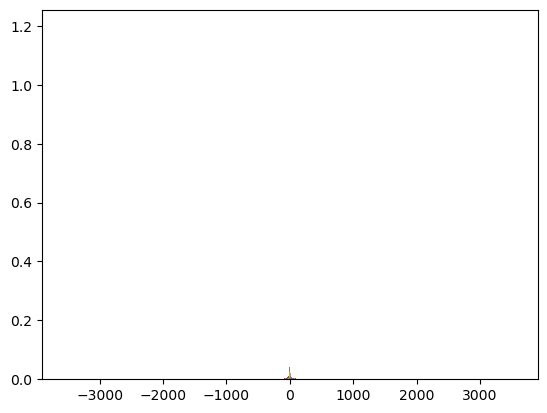

In [147]:
import numpy as np

# Calculate the radial wavenumber for each entry in fftimages
kx, ky = np.meshgrid(np.fft.rfftfreq(sub_image_size), np.fft.fftfreq(sub_image_size))
k = np.sqrt(kx**2 + ky**2)*sub_image_size 
# Flatten the wavenumber array
#k_flat = k.flatten()

logkmin = np.log10(3)
logkmax = np.log10(np.max(k))
dlogk = 0.1
max_std_out = 8


numbins = int((logkmax - logkmin)/dlogk)
kbins = np.logspace(logkmin, logkmax, numbins)
total_max =0; total_KL =0
print("numkbins=", numbins, "num_iamges_use=", num_images_use)
for kmin, kmax in zip(kbins[:-1], kbins[1:]):
    # Create a boolean mask for the desired wavenumber bin
    mask = (k >= kmin) & (k < kmax)

    #    Select the first n images
    fftimages_nr = [fftimages[i][mask].real for i in range(num_images_use)]
    fftimages_ni = [fftimages[i][mask].imag for i in range(num_images_use)]

    # Apply the mask to the flattened images
    fftimages_flatten = np.array(np.concatenate((fftimages_nr, fftimages_ni), axis=1)).flatten()

    sigma = np.std(fftimages_flatten)
    #print(sigma)

    # Plot the histogram
    plt.hist(fftimages_flatten, bins=200, range=[-max_std_out*sigma, max_std_out*sigma], density=True)

    hist, bin_edges = np.histogram(fftimages_flatten, bins=200, range=[-max_std_out*sigma, max_std_out*sigma], density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Create a boolean mask for non-zero elements
    maskhist = (hist != 0)

    #print(hist[mask])
    # Apply the mask to hist and calculate the sum
    KLDiv = np.sum(hist[maskhist] * np.log2(hist[maskhist] / (norm.pdf(bin_centers[maskhist], 0, sigma))))

    numpix =2*np.sum(mask) #2 is for real and imaginary parts
    print(kmin, kmax, "KL div = ", KLDiv, "numpix=", numpix)
   
    total_max += numpix
    total_KL += KLDiv*numpix

print("total KL = ", total_KL/total_max, " and to check I'm looking at all the pixels ", total_max, sub_image_size**2)